# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

There's also a cell that allows us to step through hyperparamters for any particular model to examine how the model overfits as a hyparameter changes.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you should select your final/best model and hyperparameters to run one time only and then make the business performance tables for that final model. Note once we've decided on the final model and hyperparameters we're allowed to make several trial runs of our final model train looking for a good performance on the testing data, as long as we don't make any changes to the model hyperparameters from our final choice.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [1]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import random
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# This will let you see all the particular library vertsions you have loaded
# %pip list

In [3]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(97496, 22)
CPU times: total: 203 ms
Wall time: 600 ms


,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0,...,Cardnum_unique_count_for_card_state_3,Cardnum_unique_count_for_card_zip_3,Merchnum_desc_Zip_total_3,Cardnum_unique_count_for_Merchnum_3,Cardnum_actual/toal_1,Cardnum_unique_count_for_card_state_7,Cardnum_actual/max_0,Card_dow_unique_count_for_merch_state_1,Recnum,Fraud
0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,1.0,...,1,1,3.62,1,1.0,1,1.0,1,1,0
1,1,31.42,0.033333,31.42,0.000011,0.000049,31.42,31.42,1,1.0,...,1,1,31.42,1,1.0,1,1.0,1,2,0
2,1,178.49,0.033333,178.49,0.000011,0.000049,178.49,178.49,1,1.0,...,1,1,178.49,1,1.0,1,1.0,1,3,0
3,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,1.0,...,1,1,3.62,1,1.0,1,1.0,1,4,0
4,1,7.24,0.033333,3.62,0.016667,0.071429,7.24,7.24,1,0.5,...,1,1,7.24,1,0.5,1,1.0,1,5,0


In [4]:
# set the number of variables desired here, and set the names of the y and record label properly
NVARS = 10

# vars.rename(columns={'record':'Recnum'},inplace=True)
# vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
detect_rate = .03
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'Cardnum_unique_count_for_card_state_1',
 'Card_Merchdesc_State_total_7',
 'Cardnum_count_1_by_30',
 'Cardnum_max_14',
 'Card_dow_vdratio_0by60',
 'Card_dow_vdratio_0by14',
 'Merchnum_desc_State_total_3',
 'Card_Merchdesc_total_7',
 'Card_dow_unique_count_for_merch_zip_7',
 'Cardnum_actual/toal_0']

In [5]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0
0,1,0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,1.0
1,2,0,1,31.42,0.033333,31.42,0.000011,0.000049,31.42,31.42,1,1.0
2,3,0,1,178.49,0.033333,178.49,0.000011,0.000049,178.49,178.49,1,1.0
3,4,0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,1.0
4,5,0,1,7.24,0.033333,3.62,0.016667,0.071429,7.24,7.24,1,0.5


In [6]:
vars.shape

(97496, 12)

In [7]:
vars['Fraud'].sum()

2047

In [8]:
print("fraud rate in data is",vars['Fraud'].sum()/len(vars))

fraud rate in data is 0.020995733158283417


In [9]:
vars.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0
0,1,0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,1.000000
1,2,0,1,31.42,0.033333,31.42,0.000011,0.000049,31.42,31.42,1,1.000000
2,3,0,1,178.49,0.033333,178.49,0.000011,0.000049,178.49,178.49,1,1.000000
3,4,0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,1.000000
4,5,0,1,7.24,0.033333,3.62,0.016667,0.071429,7.24,7.24,1,0.500000
5,6,0,1,3.67,0.033333,3.67,0.000011,0.000049,3.67,3.67,1,1.000000
6,7,0,1,3.62,0.033333,3.62,0.000011,0.000049,7.24,3.62,1,1.000000
7,8,0,1,230.32,0.033333,230.32,0.000011,0.000049,230.32,230.32,1,1.000000
8,9,0,1,62.11,0.033333,62.11,0.000011,0.000049,62.11,62.11,1,1.000000
9,10,0,1,10.86,0.033333,3.62,0.016667,0.071429,10.86,10.86,1,0.333333


In [10]:
vars.shape

(97496, 12)

In [11]:
vars.describe()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0
count,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000
mean,48915.137247,0.020996,1.724266,676.571639,0.008823,1194.385741,0.003231,0.020482,1413.472998,676.717953,1.892016,0.765940
std,28262.212670,0.143371,1.568565,4074.921736,0.008372,1856.894526,0.004996,0.026914,5123.221915,4074.945381,1.874101,0.355093
min,1.000000,0.000000,1.000000,0.010000,0.000078,0.140000,0.000007,0.000039,0.010000,0.010000,1.000000,0.000014
25%,24428.750000,0.000000,1.000000,52.500000,0.003226,307.000000,0.000152,0.001587,99.900000,52.500000,1.000000,0.500000
50%,48916.000000,0.000000,1.000000,189.000000,0.005556,801.660000,0.000370,0.002976,356.450000,189.000000,1.000000,1.000000
75%,73402.250000,0.000000,2.000000,590.000000,0.011111,1743.000000,0.004762,0.042857,1325.600000,590.000000,2.000000,1.000000
max,97852.000000,1.000000,21.000000,306633.410000,0.033333,47900.000000,0.016667,0.071429,307302.580000,306633.410000,38.000000,1.000000


In [12]:
# find the row i vars that corresponds to 11/1 for the OOT
test = vars[vars['Recnum'] > 85264]
test.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0
84935,85265,0,1,174.61,0.016667,225.00,0.000074,0.000317,174.61,174.61,1,1.0
84936,85266,0,1,53.00,0.002778,395.00,0.000278,0.001190,53.00,53.00,1,1.0
84937,85267,0,1,25.00,0.004762,531.25,0.000417,0.002976,25.00,25.00,2,1.0
84938,85268,0,1,97.17,0.004762,395.04,0.000194,0.001661,97.17,97.17,1,1.0
84939,85269,0,1,6.51,0.016667,6.51,0.000167,0.001429,6.51,6.51,1,1.0
84940,85270,0,1,170.00,0.016667,170.00,0.000260,0.001116,170.00,170.00,1,1.0
84941,85271,0,1,250.00,0.002564,250.00,0.000149,0.001786,250.00,250.00,2,1.0
84942,85272,0,1,15.00,0.016667,103.60,0.000167,0.001429,15.00,15.00,1,1.0
84943,85273,0,1,300.00,0.006667,2105.00,0.000024,0.001984,300.00,300.00,1,1.0
84944,85274,0,1,133.20,0.002564,268.20,0.001042,0.004464,133.20,133.20,2,1.0


In [13]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0
1,0
2,0
3,0
4,0


## Scale and truncate field values

In [14]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0
count,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000
mean,1.724266,676.571639,0.008823,1194.385741,0.003231,0.020482,1413.472998,676.717953,1.892016,0.765940
std,1.568565,4074.921736,0.008372,1856.894526,0.004996,0.026914,5123.221915,4074.945381,1.874101,0.355093
min,1.000000,0.010000,0.000078,0.140000,0.000007,0.000039,0.010000,0.010000,1.000000,0.000014
25%,1.000000,52.500000,0.003226,307.000000,0.000152,0.001587,99.900000,52.500000,1.000000,0.500000
50%,1.000000,189.000000,0.005556,801.660000,0.000370,0.002976,356.450000,189.000000,1.000000,1.000000
75%,2.000000,590.000000,0.011111,1743.000000,0.004762,0.042857,1325.600000,590.000000,2.000000,1.000000
max,21.000000,306633.410000,0.033333,47900.000000,0.016667,0.071429,307302.580000,306633.410000,38.000000,1.000000


In [15]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [16]:
# Outlier treatment: use this to limit variables. For some problems it helps
Clip = 10

In [17]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
X = (X - X.mean()) / X.std()
X.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0
count,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04
mean,1.049460e-17,-7.287917e-18,-5.830333e-19,7.870950e-18,-1.472159e-17,1.224370e-17,-1.166067e-18,-1.049460e-17,3.119228e-17,-4.372750e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.651796e-01,-3.346282e-01,-1.044444e+00,-7.194261e-01,-6.452996e-01,-7.595529e-01,-4.318529e-01,-3.346955e-01,-5.031954e-01,-2.156969e+00
25%,-4.651796e-01,-3.065413e-01,-6.685133e-01,-5.318162e-01,-6.163864e-01,-7.020303e-01,-3.999404e-01,-3.066096e-01,-5.031954e-01,-7.489285e-01
50%,-4.651796e-01,-2.335016e-01,-3.902418e-01,-2.293881e-01,-5.725765e-01,-6.504263e-01,-3.179788e-01,-2.335723e-01,-5.031954e-01,6.591519e-01
75%,1.782986e-01,-1.893059e-02,2.733285e-01,3.461339e-01,3.065090e-01,8.313456e-01,-8.358364e-03,-1.900840e-02,6.696772e-02,6.591519e-01
max,1.009425e+01,2.183188e+01,2.927610e+00,1.136351e+01,2.689572e+00,1.892914e+00,1.638719e+01,2.183128e+01,1.069083e+01,6.591519e-01


In [18]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this OOT record number to whatever is appropriate for your data
oot_recnum = 85264
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]
Y_oot.sum()

Fraud    297
dtype: int64

## Look at PCA

In [19]:
len(X_trntst.columns)

10

In [20]:
X_trntst_save = X_trntst.copy()

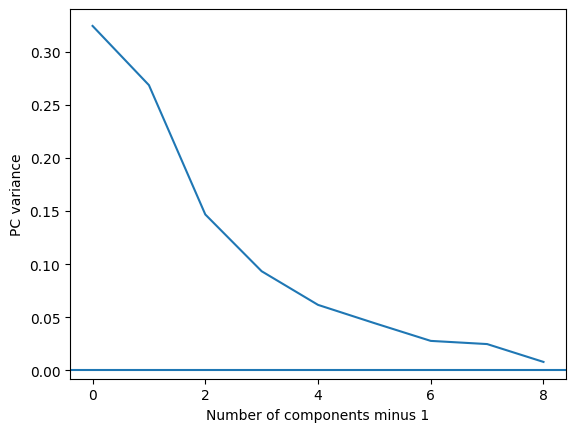

In [21]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [22]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4
0,-1.233799,-0.146768,-1.261853,2.670857
1,-1.217854,-0.125352,-1.258504,2.668163
2,-1.133501,-0.012059,-1.240786,2.653911
3,-1.233799,-0.146768,-1.261853,2.670857
4,1.747323,-2.263030,-3.108010,1.383728


In [23]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4
85264,0.474670,-0.992169,1.246312,-0.399651
85265,1.595099,-2.099471,-2.338872,1.408899
85266,-0.171959,1.949085,-0.161534,0.375554
85267,-1.073062,0.429463,0.660778,-0.213056
85268,-1.238510,0.678886,-0.019114,-0.217072


In [24]:
X_trntst.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0
count,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000
mean,0.004006,0.002794,-0.013411,0.003866,0.000122,0.003494,0.011369,0.002805,0.004227,-0.007076
std,1.007299,1.029148,0.996083,0.988241,0.999618,1.000623,1.038863,1.029151,1.014974,1.003383
min,-0.465180,-0.334628,-1.044444,-0.719426,-0.645300,-0.759504,-0.431853,-0.334696,-0.503195,-2.156969
25%,-0.465180,-0.307403,-0.680554,-0.528478,-0.616386,-0.699287,-0.400153,-0.307467,-0.503195,-0.748928
50%,-0.465180,-0.234920,-0.390242,-0.220376,-0.572577,-0.640374,-0.318782,-0.234966,-0.503195,0.659152
75%,0.178299,-0.019391,0.273329,0.354082,0.306509,0.831346,-0.004259,-0.019273,0.066968,0.659152
max,10.094246,21.831881,2.927610,11.363510,2.689572,1.892914,16.387194,21.831284,10.690830,0.659152


In [25]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12232.000000,12232.000000,12232.000000,12232.000000
mean,-0.084839,-0.037318,-0.060807,0.090004
std,1.689561,1.360119,1.158176,0.966594
min,-1.696425,-6.345955,-4.842932,-4.632864
25%,-1.295068,-0.697445,-0.557728,-0.438803
50%,-0.893845,0.194860,-0.029108,-0.109650
75%,1.045609,0.502024,0.389831,0.438306
max,21.527572,29.137615,9.748135,5.452739


In [26]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [27]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4
count,8.526400e+04,8.526400e+04,8.526400e+04,8.526400e+04
mean,1.533354e-17,-8.000106e-18,-8.666781e-18,8.666781e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.533328e-01,-4.052689e+00,-5.196134e+00,-4.686439e+00
25%,-6.921927e-01,-4.952199e-01,-4.252566e-01,-5.479011e-01
50%,-4.120381e-01,1.169866e-01,1.252057e-02,-1.881926e-01
75%,5.904588e-01,3.207532e-01,3.698016e-01,3.265700e-01
max,1.341726e+01,1.839694e+01,1.136849e+01,6.388562e+00


In [28]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12232.000000,12232.000000,12232.000000,12232.000000
mean,-0.046605,-0.022527,-0.049643,0.092140
std,0.928131,0.821052,0.945546,0.989529
min,-0.931901,-3.830809,-3.953814,-4.742789
25%,-0.711423,-0.421021,-0.455334,-0.449215
50%,-0.491018,0.117629,-0.023764,-0.112251
75%,0.574387,0.303053,0.318262,0.448706
max,11.825793,17.589258,7.958466,5.582118


In [29]:
X_trntst_pca.shape

(85264, 4)

In [30]:
X_oot_orig_pca.shape

(12232, 4)

## Subsample the larger class if desired

In [31]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.020524488647025708
(3464, 10) 3464


In [32]:
# We do a manual cross validation by running each model nitermax times for each choice of hyperparameters. The good
# statistical measurement of the model performance is the average across all these nitermax runs.
niter = 0
nitermax = 10
jittersize = .1
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and/or just explore one model type. You can also just rerun any single cell multiple times (hit shift-enter on that cell) as you "manually" explore different model hyperparameters.

In [33]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [34]:
%%time
# Logistic regression

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression(penalty='l1', solver='liblinear' ,  C=0.5, max_iter=150)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.6900247320692497 0.6573556797020484 0.46464646464646464
1 0.683265306122449 0.6742857142857143 0.46464646464646464
2 0.6727574750830565 0.6959706959706959 0.46464646464646464
3 0.6814011676396997 0.6896551724137931 0.46464646464646464
4 0.6737704918032786 0.6924528301886792 0.468013468013468
5 0.6950122649223222 0.6584440227703985 0.468013468013468
6 0.6843413421706711 0.6777163904235728 0.46464646464646464
7 0.6824104234527687 0.6762452107279694 0.4612794612794613
8 0.6942622950819672 0.6471698113207547 0.4713804713804714
9 0.6782464846980976 0.6876155268022182 0.47474747474747475
trn    0.683549
tst    0.675691
oot    0.466667
dtype: float64
CPU times: total: 54.8 s
Wall time: 1min 29s


In [35]:
%%time
# Single DT

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(splitter='best',max_depth=10,min_samples_split=50,min_samples_leaf=25)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1

print(FDR.mean())
model_counter = model_counter + 1

0 0.7844611528822055 0.7450271247739603 0.5757575757575758
1 0.79766860949209 0.7377049180327869 0.5589225589225589
2 0.7854889589905363 0.7302904564315352 0.5723905723905723
3 0.7886977886977887 0.7391304347826086 0.494949494949495
4 0.7771520514883347 0.7731755424063116 0.5925925925925926
5 0.7841552142279709 0.7309941520467836 0.5757575757575758
6 0.7893442622950819 0.7339622641509433 0.5387205387205387
7 0.7784090909090909 0.7432432432432432 0.5723905723905723
8 0.7777777777777778 0.7559055118110236 0.5555555555555556
9 0.7833197056418643 0.7343453510436433 0.5555555555555556
trn    0.784647
tst    0.742378
oot    0.559259
dtype: float64
CPU times: total: 3.28 s
Wall time: 5.66 s


In [36]:
%%time
# RF

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = RandomForestClassifier(n_estimators=100,max_depth=10,min_samples_split=80,min_samples_leaf=40,max_features=13)
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.7743221690590112 0.7358870967741935 0.494949494949495
1 0.7735697018533441 0.75049115913556 0.5589225589225589
2 0.7660626029654036 0.7444029850746269 0.5151515151515151
3 0.7754098360655738 0.7264150943396226 0.5824915824915825
4 0.7752255947497949 0.7419962335216572 0.5286195286195287
5 0.7657004830917874 0.7618110236220472 0.5757575757575758
6 0.7637407711238721 0.7532956685499058 0.5185185185185185
7 0.779126213592233 0.7509727626459144 0.5151515151515151
8 0.7738287560581584 0.71484375 0.5353535353535354
9 0.7673060884070059 0.7332123411978222 0.5723905723905723
trn    0.771429
tst    0.741333
oot    0.539731
dtype: float64
CPU times: total: 3min 41s
Wall time: 5min 28s


In [37]:
%%time
# LGBM

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(n_estimators= 30, num_leaves= 5, max_depth= 3, min_child_samples= 60)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

c:\Users\Facundo\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Facundo\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Number of positive: 1225, number of negative: 58459
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2080
[LightGBM] [Info] Number of data points in the train set: 59684, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020525 -> initscore=-3.865385
[LightGBM] [Info] Start training from score -3.865385
0 0.7444897959183674 0.7561904761904762 0.5252525252525253
[LightGBM] [Info] Number of positive: 1232, number of negative: 58452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2080
[LightGBM] [Info] Number of data points in the train set: 59684, number of used features: 10
[LightGBM] [Info] [binary

In [38]:
# %%time
# # LGBM with SMOTE
# from imblearn.over_sampling import SMOTE

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
#     sm = SMOTE()
    
#     X_trn_sm, Y_trn_sm = sm.fit_resample(X_trn,Y_trn)
    
#     print(niter, X_trn.shape,Y_trn.shape)
#     print(niter, X_trn_sm.shape,Y_trn_sm.shape)
#     print(Y_trn.sum())
#     print(Y_trn_sm.sum())

#     model = lgb.LGBMClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn_sm, Y_trn_sm.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['LGBM with SMOTE',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [39]:
# %%time
# # LGBM with jitter

# jittersize = .1
# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
#     print(niter, X_trn.shape,Y_trn.shape)
    
#     X_trn_bads = X_trn[Y_trn == 1]
#     Y_trn_bads = Y_trn[Y_trn == 1]
    
#     print(X_trn_bads.head())
#     for i in range(2):
#         X_trn_more = X_trn_bads*(1+jittersize*random.uniform(-1,1))
#         X_trn = X_trn.append(X_trn_more,ignore_index=True)
#         Y_trn = Y_trn.append(Y_trn_bads,ignore_index=True)
        
#     print(niter, X_trn.shape,Y_trn.shape)

#     model = lgb.LGBMClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['LGBM with jitter',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [40]:
# NN

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
      
    model = MLPClassifier(hidden_layer_sizes=(15,15,15,15),learning_rate_init=0.001, momentum=0.9)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.7908286403861625 0.7416173570019724 0.5016835016835017
1 0.807258064516129 0.7607843137254902 0.5488215488215489
2 0.7996702390766695 0.7411545623836127 0.5286195286195287
3 0.7998338870431894 0.7490842490842491 0.5387205387205387
4 0.794331983805668 0.7514563106796116 0.4612794612794613
5 0.8128119800332779 0.7463503649635036 0.5016835016835017
6 0.7938487115544473 0.7678244972577697 0.5218855218855218
7 0.7960363336085879 0.7476808905380334 0.5252525252525253
8 0.8057142857142857 0.7219047619047619 0.5185185185185185
9 0.7936 0.724 0.5016835016835017
trn    0.799393
tst    0.745186
oot    0.514815
dtype: float64


In [41]:
# %%time
# # NN on pc's

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = MLPClassifier(hidden_layer_sizes=(20,))

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['NN_PCs',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [42]:
# %%time
# # GBC

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = GradientBoostingClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['GBC',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [43]:
%%time
# Catboost

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(verbose=0,learning_rate=.02,l2_leaf_reg=3,depth=3,min_data_in_leaf=60)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.7660098522167488 0.7744360902255639 0.5286195286195287
1 0.7734187349879904 0.7544910179640718 0.4983164983164983
2 0.7733664185277088 0.7338262476894639 0.5016835016835017
3 0.7736928104575164 0.7585551330798479 0.5252525252525253
4 0.7681274900398406 0.7777777777777778 0.4983164983164983
5 0.7739888977002379 0.7464212678936605 0.494949494949495
6 0.7701516360734237 0.7545271629778671 0.4983164983164983
7 0.7772236076475478 0.7495429616087751 0.5084175084175084
8 0.7688483844241922 0.7458563535911602 0.4983164983164983
9 0.7629449838187702 0.7665369649805448 0.5050505050505051
trn    0.770777
tst    0.756197
oot    0.505724
dtype: float64
CPU times: total: 3min 47s
Wall time: 2min 26s


In [44]:
# %%time
# # NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# # Only use this cell if you do downsampling of the goods.
# # each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# # it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

# xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
# print(xmult)
# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

#     model = lgb.LGBMClassifier()

#     model.fit(X_trn, Y_trn.values.ravel())  
    
#     X_oot = X_oot_orig.copy()
#     X_trn = X_trntst.copy()
#     Y_trn = Y_trntst.copy()
#     X_tst = X_trntst.copy()
#     Y_tst = Y_trntst.copy()

#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['LGBM sampled',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [45]:
# %%time
# # Catboost on pc's

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = CatBoostClassifier()

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost_PCs',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [46]:
# %%time
# # unsupervised model using pc's. 

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     pow = 2
#     oop = 1/pow
#     predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['unsupervised outliers',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [47]:
# %%time
# # XGB

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = xgb.XGBClassifier(booster='gbtree')

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['XGB',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [48]:
# %%time
# # Knn
# # Knn can be very slow with a lot of records.

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
#     model = KNeighborsClassifier() 
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['Knn',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [49]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(kernel='poly',probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [50]:
df = Modeling_output.dropna()
df.tail(20)

,Model,Trn,Tst,OOT
40,NN,0.790829,0.741617,0.501684
41,NN,0.807258,0.760784,0.548822
42,NN,0.79967,0.741155,0.52862
43,NN,0.799834,0.749084,0.538721
44,NN,0.794332,0.751456,0.461279
45,NN,0.812812,0.74635,0.501684
46,NN,0.793849,0.767824,0.521886
47,NN,0.796036,0.747681,0.525253
48,NN,0.805714,0.721905,0.518519
49,NN,0.7936,0.724,0.501684


In [51]:
df.shape

(60, 4)

In [52]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.690025
1,log reg,Trn,0.683265
2,log reg,Trn,0.672757
3,log reg,Trn,0.681401
4,log reg,Trn,0.67377


In [53]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.690025
1,log reg,Trn,0.683265
2,log reg,Trn,0.672757
3,log reg,Trn,0.681401
4,log reg,Trn,0.67377


In [54]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
               mean       std      mean       std      mean       std
Model                                                                
DT         0.784647  0.006263  0.742378  0.013261  0.559259  0.027050
LGBM       0.756354  0.008872  0.742561  0.018123  0.542761  0.016014
NN         0.799393  0.007123  0.745186  0.014290  0.514815  0.024663
RF         0.771429  0.005228  0.741333  0.014020  0.539731  0.030492
cat boost  0.770777  0.004337  0.756197  0.013597  0.505724  0.011856
log reg    0.683549  0.007709  0.675691  0.016610  0.466667  0.003952

In [55]:
df.head()

,Model,Trn,Tst,OOT
0,log reg,0.690025,0.657356,0.464646
1,log reg,0.683265,0.674286,0.464646
2,log reg,0.672757,0.695971,0.464646
3,log reg,0.681401,0.689655,0.464646
4,log reg,0.67377,0.692453,0.468013


In [56]:
best_OOT = df['OOT'].max()
best_OOT

0.5925925925925926

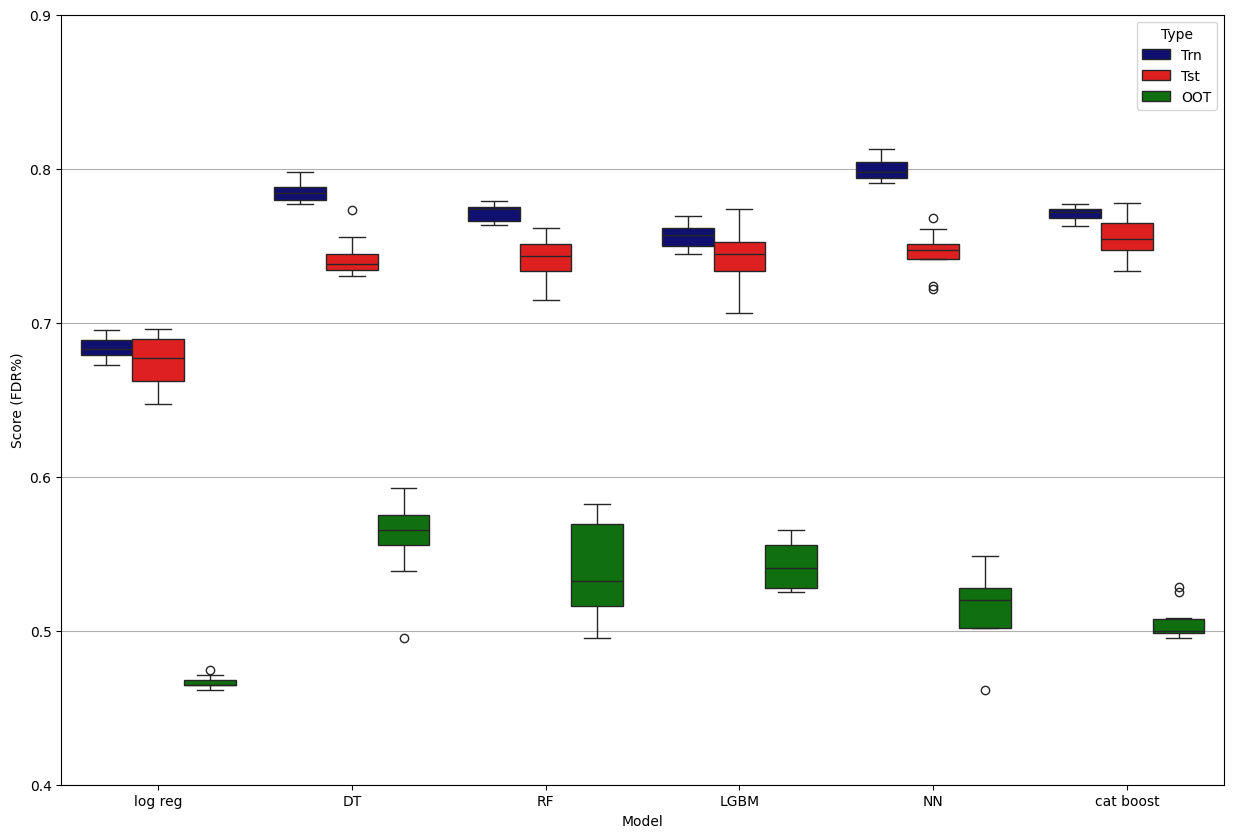

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.4,0.9)
plt.ylabel('Score (FDR%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [60]:
print('duration: ', datetime.now() - start_time)

duration:  0:36:41.175076


This next cell can be used to explore overfitting

0 0.7901929260450161 0.7529644268774703 0.5084175084175084
1 0.7748123436196831 0.7531760435571688 0.5117845117845118
2 0.7701056051990252 0.7707129094412332 0.531986531986532
loop trn tst oot 3 0.7783702916212415 0.7589511266252907 0.5173961840628508
0 0.7767068273092369 0.7445544554455445 0.49158249158249157
1 0.7647540983606558 0.7716981132075472 0.4882154882154882
2 0.751818916734034 0.7797270955165692 0.5016835016835017
loop trn tst oot 4 0.7644266141346422 0.7653265547232203 0.49382716049382713
0 0.7657370517928287 0.7656565656565657 0.4983164983164983
1 0.7778681855166802 0.7485604606525912 0.49158249158249157
2 0.7681744749596123 0.771484375 0.5286195286195287
loop trn tst oot 5 0.7705932374230403 0.7619004671030524 0.5061728395061729
0 0.7844408427876823 0.7461240310077519 0.48484848484848486
1 0.7799196787148595 0.7702970297029703 0.5151515151515151
2 0.7760330578512397 0.7685185185185185 0.5185185185185185
loop trn tst oot 6 0.7801311931179272 0.7616465264097468 0.5061728395

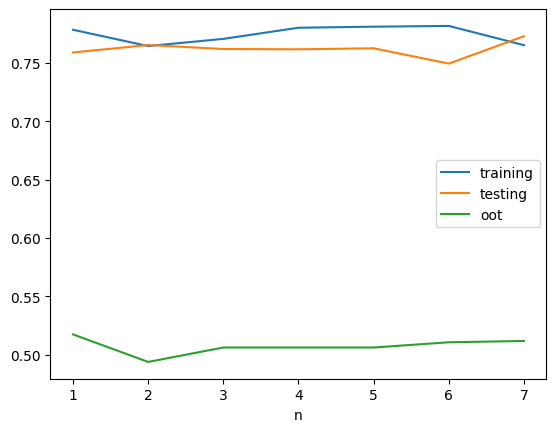

CPU times: total: 10min
Wall time: 5min 32s


In [59]:
%%time
# This cell is used only to examine overfitting for any particular model type.
# One can iterate through a hyperparameter's value, either increasing or decreasing it, and watching the overfitting.
nitermax2 = 3 # Lower the number of model builds for each value of hyperparameters so this cell runs faster.
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])

# Here's where we set the manner of the hyperparameter's ranga and increment.
for i in range(3,10,1):

# Now just run the model as before.
    for niter in range(nitermax2):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
  
        io2 = int(i/2) # the min_samples_leaf can be set to half the min_samples_split for simplicity.
        model = CatBoostClassifier(verbose=0,learning_rate=.02,l2_leaf_reg=3,depth=3,min_data_in_leaf=60)

        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*detect_rate))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*detect_rate))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*detect_rate))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'n': range(1,len(training)+1),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
table.plot()
plt.savefig('complexity_NN.pdf', format='pdf')
plt.show()

In [ ]:
best_OOT

The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [ ]:
%%time
# Note - need to set this next value to around the highest oot fdr for your model of choice.
# The model then runs a nombermof times with your fixed hyperparameters until it finds a good model.
desire = .55
print('desire =', desire)
for niter in range(50):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# Here's where you put your final model of choice.
# I run this loop a large number of times with an unreasonably high stopping criterion (the break condition)
# I then look at all these runs and select a value of the oot performance where I want to break out this loop
# and that will be my final model run of choice.
    model = lgb.LGBMClassifier()

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
# choose a good break point
    if(FDR.loc[niter, 'oot'] > desire): break
    
model_counter = model_counter + 1

In [62]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [ ]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

In [ ]:
cost_fraud = 400
cost_fp = 20
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud
    FDR_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp
    FDR_trn.loc[i, 'Overall Savings'] = FDR_trn.loc[i, 'Fraud Savings'] - FDR_trn.loc[i, 'FP Loss']
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud
    FDR_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp
    FDR_tst.loc[i, 'Overall Savings'] = FDR_tst.loc[i, 'Fraud Savings'] - FDR_tst.loc[i, 'FP Loss']
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot

    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

In [ ]:
# xmult: oot is only 2 out of 12 months. 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_trn = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_tst = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud * xoot
    Financials_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp * xoot
    Financials_trn.loc[i, 'Overall Savings'] = Financials_trn.loc[i, 'Fraud Savings'] - Financials_trn.loc[i, 'FP Loss']
    Financials_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud * xoot
    Financials_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp * xoot
    Financials_tst.loc[i, 'Overall Savings'] = Financials_tst.loc[i, 'Fraud Savings'] - Financials_tst.loc[i, 'FP Loss']
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
xlimit = 20
interval = 1
plt.xlim(0,xlimit)
plt.ylim(0,yupper)
plt.xticks(ticks=np.linspace(0,xlimit, num=int(xlimit/interval)+1))
plt.ticklabel_format(style='plain')
plt.savefig('savings.png', format='png')

In [ ]:
FDR_oot.head(10)

In [67]:
FDR.to_csv('FDR.csv')

In [68]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [ ]:
Metrics = FDR_oot.copy()
num_good = Metrics['#g'].sum()
num_bad = Metrics['#b'].sum()
num_tot = Metrics['#recs'].sum()
print(num_good,num_bad,num_good+num_bad,num_tot)

In [70]:
Metrics['TP'] = Metrics['cb']
Metrics['TN'] = num_good - Metrics['cg']
Metrics['FN'] = num_bad - Metrics['cb']
Metrics['FP'] = Metrics['cg']
Metrics['Accuracy'] = (Metrics['TP'] + Metrics['TN']) / num_tot
Metrics['Misclass'] = (Metrics['FP'] + Metrics['FN']) / num_tot
Metrics['FPRate'] = Metrics['FP'] / (Metrics['FP'] + Metrics['TN'])
Metrics['FPRatio'] = Metrics['FP'] / Metrics['TP']
Metrics['TPR'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FN'])
Metrics['TNR'] = Metrics['TN'] / (Metrics['TN'] + Metrics['FP'])
Metrics['Precision'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FP'])
Metrics['f1'] = 2 * Metrics['Precision'] * Metrics['TPR'] / (Metrics['Precision'] + Metrics['TPR'])
Metrics.to_csv('Metrics.csv')

In [ ]:
plt.rcParams.update({'font.size':10})
plt.plot(Metrics['bin'], Metrics['TPR'])
plt.title('Fraud Detection Rate', fontsize=20)
plt.xlim(0,10)
plt.ylim(0,1)
plt.xlabel('Score cutoff %', fontsize=15)
plt.ylabel('FDR', fontsize=15)

For a highly imbalanced problem the # goods in each bin is close to constant except for the first few bins, so the FDR curve (xaxis is bin #) and the ROC (x axis is FP, which is # goods below the cutoff) look very similar. They're only different in the first few bins where the # goods are not ~constant.

In [ ]:
plt.plot(Metrics['FPRate'], Metrics['TPR'])
plt.title('ROC', fontsize=20)
plt.xlabel('FPRate',fontsize=15)
plt.ylabel('TPRate', fontsize=15)
plt.xlim(0,1)
plt.ylim(0,1)

In [ ]:
print("duration: ", datetime.now() - start_time)

In [ ]:
%pwd

In [ ]:
%%time
df = pd.read_csv('card transactions.csv')
df.dropna(how='all', axis=1, inplace=True)
df = df[df['Transtype'] == 'P']
df = df[df['Amount'] <= 3000000]
df['Date'] = pd.to_datetime(df['Date'])
df.shape

In [76]:
df['prediction'] = model.predict_proba(X)[:,1]

In [77]:
pred_scale = 1/df['prediction'].max()
df['prediction'] = df['prediction']*pred_scale

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df_sorted = df.sort_values(by=['prediction'],ascending=False)
df_sorted.head(20)

# Here we're going to look at specific cards or merchants to look at the dynamics of the fraud score

In [ ]:
bads = df[df['Fraud']==1]
bads['Cardnum'].value_counts().head(20)

In [ ]:
bads['Merchnum'].value_counts().head(15)

In [ ]:
card = 5142140316
# card = 5142847398
# card = 5142199009
# card = 5142160778
# card = 5142189341
# card = 5142181728
# card = 5142212038
# card = 5142220919
# card = 5142214614
# card = 5142202847
# card = 5142138135
# card = 5142271065
# card = 5142152857
# card = 5142179617
# card = 5142235211
# card = 5142197711
# card = 5142182128
# card = 5142189113
# card = 5142197563 

merch = 4353000719908
# merch = 930090121224  
# merch = 48834000695423
# merch = 44503738417400
# merch = 44620009957157
# merch = 4618901687330
# merch = 4900009045549
# merch = 49108234610000
# merch = 4253052983001
# merch = 4938909877224
# merch = 44503082476300
# merch = 46006333528866
# merch = 4997674930332
# merch = 46070095870009
# merch = 49900020006406
sample = df[df['Cardnum'] == card]
# sample = df[df['Merchnum'] == str(merch)]
sample['Fraud'].sum()

In [ ]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(sample['Date'],sample['prediction'])
plt.plot_date(sample['Date'],sample['Fraud'])

In [ ]:
tsample = sample[sample['Date'] > '2010-08-01']
tsample = tsample[tsample['Date'] < '2010-09-10']
tsample.reset_index(inplace=True)
tsample.reset_index(inplace=True)
tsample.rename(columns={'level_0':'counter'},inplace=True)
tsample['counter'] = tsample['counter']+1
tsample.head()

In [ ]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['Date'],tsample['prediction'])
plt.plot_date(tsample['Date'],tsample['Fraud'])
plt.savefig('dynamics_time.png', format='png')

In [ ]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['counter'],tsample['prediction'])
plt.scatter(tsample['counter'],tsample['Fraud'])
plt.savefig('dynamics_count.png', format='png')

In [ ]:
tsample.to_csv('dynamics_transactions.csv')
tsample.head(40)

In [ ]:
len(tsample)

# Score Calibration

In [90]:
base = 600
delta = 20
odds_at_base = .1

In [ ]:
df = pd.concat([X_trn_eval,X_tst_eval,X_oot_eval])
df.shape

In [ ]:
df.head()

In [ ]:
calib = df.iloc[:,df.shape[1]-2:]
trn_sorted = X_trn_eval.sort_values('predicted',ascending=True)
calib = calib.sort_values('predicted')
calib.rename(columns={'predicted':'score_raw'}, inplace=True)
calib['score_raw'].clip(upper=.999, inplace=True)
calib['score_raw'].clip(lower=.00001, inplace=True)
calib.head()

In [ ]:
calib.shape

In [ ]:
plt.hist(calib['score_raw'],bins=100)
plt.yscale('log')

In [96]:
# The reason we bin the records is to calculate the odds. We can then find the relationship between the raw score and the log odds.
nbins=100
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','score_raw','prob(%)','odds','log_odds', 'log_odds_adj']
cal_bins = pd.DataFrame(np.zeros((nbins+1, 14)), columns = cols)

In [ ]:
bad_tot = sum(calib.loc[:, 'Fraud'])
good_tot = len(calib) - bad_tot
print(bad_tot, good_tot)

In [ ]:
frac = 1/nbins
nrecs = calib.shape[0]
cal_bins.loc[0,'log_odds_adj'] = -8
for i in range(nbins+1):
    percent_rows_top = int(round(nrecs*frac*i))
    percent_rows_bottom = max(int(round(nrecs*frac*(i-1))),0)
    temp = calib.iloc[percent_rows_bottom:percent_rows_top,:]
    cal_bins.loc[i, 'score_raw'] = temp['score_raw'].mean()
    num_bad = int(sum(temp.loc[:,'Fraud']))
    num_tot = len(temp) * i
    num_good = int(num_tot - num_bad)
    cal_bins.loc[i, 'bin'] = i
    cal_bins.loc[i,'#recs'] = 0
    cal_bins.loc[i, 'tot'] = num_tot
    cal_bins.loc[i, 'cg'] = num_good
    cal_bins.loc[i, 'cb'] = num_bad
    if i != 0:
        cal_bins.loc[i, '#recs'] = len(temp)
        cal_bins.loc[i, '#b'] = int(sum(temp.loc[:, 'Fraud']))
        cal_bins.loc[i, '#g'] = cal_bins.loc[i, '#recs'] - cal_bins.loc[i, '#b']
        cal_bins.loc[i, '%g'] = 100* cal_bins.loc[i, '#g'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, '%b'] = 100 - cal_bins.loc[i, '%g']
        cal_bins.loc[i, 'cg'] = cal_bins.loc[i-1, 'cg'] + cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'cb'] = cal_bins.loc[i-1, 'cb'] + cal_bins.loc[i, '#b']
        cal_bins.loc[i, 'prob(%)'] = 100 * cal_bins.loc[i, '#b'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, 'odds'] = (cal_bins.loc[i, '#b'] + .001) / cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'log_odds'] = np.log2(cal_bins.loc[i, 'odds'])
        cal_bins.loc[i, 'log_odds_adj'] = max(cal_bins.loc[i, 'log_odds'], cal_bins.loc[i-1, 'log_odds_adj'])
        
cal_bins.drop(index=0,axis=0,inplace=True)
cal_bins.fillna(0)

In [ ]:
cal_bins.tail()

In [ ]:
plt.figure(figsize=(12,4))
plt.ylim([-6,5])
plt.plot(cal_bins['score_raw'],cal_bins['log_odds'])
# plt.plot(cal_bins['score_raw'],cal_bins['log_odds_adj'])
# plt.xlim([0,1])

In [101]:
def funcg(x, a, b, c):
    return c + b/(1 + np.exp(-a * x))

def funcf(x, a, b, c):
    return -np.log(-1 + b/(x - c))/a

In [ ]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(funcg, cal_bins['log_odds_adj'],cal_bins['score_raw'])   
print(popt)

In [ ]:
# plt.plot(cal_bins['log_odds'],cal_bins['score'])
plt.plot(cal_bins['log_odds_adj'],cal_bins['score_raw'])
plt.plot(cal_bins['log_odds_adj'],funcg(cal_bins['log_odds_adj'], *popt))

In [ ]:
# look at the smooth curve fit to see if it's OK.
plt.figure(figsize=(12,4))
plt.plot(cal_bins['score_raw'], cal_bins['log_odds_adj'])
plt.plot(cal_bins['score_raw'], funcf(cal_bins['score_raw'], *popt))

In [ ]:
# The fit looks pretty good
cal_bins['fit'] = funcf(cal_bins['score_raw'], *popt)
cal_bins.head(10)

In [106]:
# Here's the calibrated score
cal_bins['score_calib'] = base + delta * cal_bins['fit'] - delta * np.log2(odds_at_base)
cal_bins['score_calib'].fillna(999, inplace=True)
cal_bins['score_calib'].clip(upper=999, inplace=True)

In [ ]:
pd.set_option('display.max_rows', 100)
cal_bins.to_csv('cal_bins.csv')
cal_bins.tail(30)

In [ ]:
calib.head()

In [ ]:
calib['score_calib'] = base - delta * np.log2(odds_at_base) + delta * funcg(calib['score_raw'], *popt)
calib['score_calib'].fillna(999, inplace=True)
calib['score_calib'].clip(upper=999, inplace=True)
calib.head()

In [ ]:
calib.tail()

In [ ]:
calib.describe()

In [ ]:
nbins=100
plt.hist(calib['score_raw'],bins=nbins)
plt.yscale('log')

In [ ]:
plt.hist(calib['score_calib'],bins=nbins)
plt.yscale('log')

In [ ]:
goods = calib[calib['Fraud']==0]
bads = calib[calib['Fraud']==1]
plt.hist(goods['score_raw'],bins = nbins, alpha = .5)
plt.hist(bads['score_raw'],bins = nbins, alpha = .5)
plt.yscale('log')

In [ ]:
plt.hist(goods['score_calib'],bins = nbins, alpha = .5)
plt.hist(bads['score_calib'],bins = nbins, alpha = .5)
plt.yscale('log')

In [ ]:
print("duration: ", datetime.now() - start_time)

In [ ]:
%pwd